In [1]:
from skimage.transform import resize
from skimage.io import imread
from skimage.draw import circle
import numpy as np
from matplotlib import pyplot as plt
import keras
import glob
import os
import pandas as pd

TRAIN_DATA_FOLDER = "./data/facial-keypoints-train/"
TEST_DATA_FOLDER = "./data/facial-keypoints-test/"
%matplotlib inline

Using TensorFlow backend.


In [2]:
train_pictures_filenames = sorted(glob.glob(os.path.join(TRAIN_DATA_FOLDER, "images/*.jpg")))
keypoints_df = pd.read_csv(os.path.join(TRAIN_DATA_FOLDER, "gt_train.csv"))

In [3]:
def split_points(array):
    size = len(array)
    points = np.zeros(shape=(size // 2, 2))
    for i in range(size // 2):
        points[i][0] = array[2 * i + 1]
        points[i][1] = array[2 * i]
    return points

In [10]:
def prepare_image(img, filename, keypoints_df, new_shape=(170, 170, 3)):
    img_shape = img.shape

    relative_filename = filename.split('/')[-1]
    img_keypoints = split_points((keypoints_df.loc[keypoints_df["filename"] == relative_filename]).as_matrix()[0][1:])
    
    k_x = float(new_shape[0]) / img_shape[0]
    k_y = float(new_shape[1]) / img_shape[1]

    new_img_keypoints = np.array(list(map(lambda x: (int(x[0] * k_x), int(x[1] * k_y)), img_keypoints)))
    new_img_keypoints = np.reshape(new_img_keypoints, -1) 
    new_img = resize(img, new_shape)
    return new_img, new_img_keypoints

In [12]:
counter = 0
num_of_imgs = 100
train_imgs = np.zeros(shape=(num_of_imgs, 170, 170, 3))
train_labels = np.zeros(shape=(num_of_imgs, 28))

for filename in train_pictures_filenames:
    img = imread(filename)
    if len(img.shape) == 3:
        prepared_img, labels = prepare_image(img, filename, keypoints_df)
        train_imgs[counter] = prepared_img
        train_labels[counter] = labels
        counter += 1
    if counter == 100:
        break

In [16]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import SGD, Adam

In [ ]:
batch_size = 32
nb_classes = 28
nb_epoch = 200
data_augmentation = True

img_rows, img_cols = 170, 170
# the CIFAR10 images are RGB
img_channels = 3

# the data, shuffled and split between train and test sets
(X_train, Y_train) = (train_imgs, train_labels)
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')

model = Sequential()

model.add(Convolution2D(32, 3, 3, border_mode='same',
                        input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(Convolution2D(32, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Convolution2D(64, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(Convolution2D(64, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes))

optimizer = Adam()
model.compile(loss='mean_squared_error',
              optimizer=optimizer)

X_train = X_train.astype('float32')

if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(X_train, Y_train,
              batch_size=batch_size,
              nb_epoch=nb_epoch,
              validation_data=(X_test, Y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')

    # this will do preprocessing and realtime data augmentation
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=180,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images

    # compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied)
    datagen.fit(X_train)

    # fit the model on the batches generated by datagen.flow()
    model.fit_generator(datagen.flow(X_train, Y_train,
                        batch_size=batch_size),
                        samples_per_epoch=X_train.shape[0],
                        nb_epoch=nb_epoch)

X_train shape: (100, 170, 170, 3)
100 train samples
Using real-time data augmentation.
Epoch 1/200


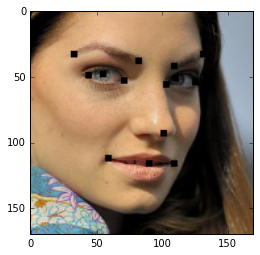

In [23]:
first_img = imread(train_pictures_filenames[0])
shape = first_img.shape
new_shape = (170, 170, 3)
first_img_res = resize(first_img, new_shape)
k_x = float(new_shape[0]) / shape[0]
k_y = float(new_shape[1]) / shape[1]

new_keypoints = map(lambda x: (int(x[0] * k_x), int(x[1] * k_y)), img_keypoints)

for keypoint in new_keypoints:
    first_img_res[circle(keypoint[0], keypoint[1], 3)] = (0, 255, 0)
plt.imshow(first_img_res)